In [1]:
%pip install python-dotenv
%pip install pyjwt[crypto]
%pip install cryptography

%load_ext dotenv
%dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# README


This is a Jupyter Notebook to experiment with the  API's. [OpenID Federation Admin Server and Federation Server](https://github.com/Sphereon-Opensource/OpenID-Federation)

You can provide custom environment options in a **.env** file, for example with this content:

```
admin_server="https://<your public address for the admin server>"
federation_server="https://<your public address for the federation server>"
openid_provider=""https://<your public address for the keycloak server>"/realms/openid-federation"
client_id="openid-client"
client_secret="<your client secret>"
```

Please share comments/suggestion/improvements:

Harry Kodden, harry-at-surf-dot-nl

In [3]:
!pip install iplantuml
import iplantuml

Writing output for /home/harry/projects/OpenID-Federation/notebook/cb84299b-1fb7-4ffe-b353-93effd802e3c.uml to cb84299b-1fb7-4ffe-b353-93effd802e3c.svg


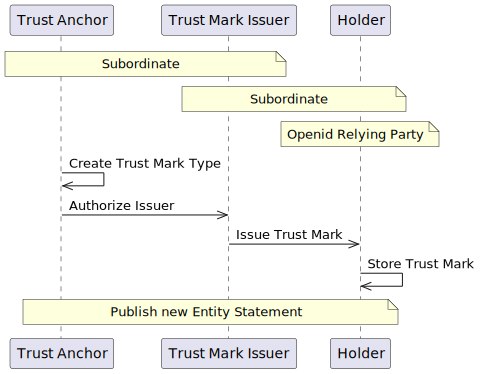

In [4]:
%%plantuml
@startuml
participant TA as "Trust Anchor"
participant TI as "Trust Mark Issuer"
participant H as "Holder"

Note over TA,TI: Subordinate
Note over TI,H: Subordinate
Note over H: Openid Relying Party

TA ->> TA: Create Trust Mark Type
TA ->> TI: Authorize Issuer
TI ->> H: Issue Trust Mark
H ->> H: Store Trust Mark
Note over TA,H: Publish new Entity Statement
@enduml

In [5]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [13]:
import requests
import json
import os
import jwt

class Federation:

    def __init__(
        self,
        federation_server="http://localhost:8080",
        admin_server="http://localhost:8081",
        openid_provider="http://localhost:8082/realms/openid-federation",
        client_id=None,
        client_secret=None
    ):
        assert client_id, "need client id for token endpoint"
        assert client_secret, "need client secret for token endpoint"

        self.admin_server = admin_server
        self.federation_server = federation_server
        self.openid_provider = openid_provider
        self.client_id = client_id
        self.client_secret = client_secret

    def access_token(self):

        token_endpoint = self.token_openid_wellknown = self.request(
            'GET', '/.well-known/openid-configuration',
            server=self.openid_provider
        ).json().get('token_endpoint')

        grant_type = "client_credentials"

        return requests.request(
            "POST", token_endpoint,
            data=f"grant_type={grant_type}&client_id={self.client_id}&client_secret={self.client_secret}",
            headers={
                "Content-Type": "application/x-www-form-urlencoded"
            }
        ).json().get('access_token')

    def request(self, method, request, server="http://localhost:8080", json=None, data=None, headers=None):

        response = requests.request(
            method,
            f"{server}{request}",
            json=json,
            data=data,
            headers=headers
        )
        if response.status_code not in [200, 201]:
            print(method, f"{server}{request}", "-->", response.status_code, response.text)
            
        return response

In [14]:
class Entity(object):

    keys = {}

    def __init__(self, federation, entity_name, identifier=None):
        self.federation = federation
        self.entity = None
        self.access_token = self.federation.access_token()

        assert self.access_token, "Get Access Token failed !"
        
        for entity in self.federation.request(
            'GET', '/accounts',
            self.federation.admin_server,
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token
            }
        ).json():
            if entity['username'] == entity_name:
                self.entity = entity

        # You may provide an explicit identifier address of your entity
        # If not provided, then the configured federation-server is taken as base address
        if not identifier:
            identifier = self.federation.federation_server + '/'
            if entity_name != 'root':
                identifier += entity_name
            
        if not self.entity:
            self.entity = self.federation.request(
                'POST', '/accounts',
                self.federation.admin_server,
                json={
                    "username": entity_name,
                    "identifier": identifier
                },
                headers={
                    "Content-Type": "application/json",
                    "Authorization": "Bearer " + self.access_token
                }
            ).json()

        for key in self.federation.request(
            'GET', '/keys',
            self.federation.admin_server,
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": entity_name
            }
        ).json():
            if key['kid'] not in self.keys:
                self.keys[key['kid']] = key
        
        self.publish()

    def public_key(self, kid):
        assert self.keys[kid], f"Missing key: {kid} !"
        return self.keys[kid]        
        
    def decode_signed_jwt(self, data):
        header = jwt.get_unverified_header(data)
        jwk = self.public_key(header['kid'])

        assert jwk, "Missing JWK !"
        
        if jwk['kty'] == 'RSA':
            key = jwt.algorithms.RSAAlgorithm.from_jwk(jwk)
        elif jwk['kty'] == 'EC':
            from cryptography.hazmat.backends import default_backend
            from cryptography.hazmat.primitives.asymmetric import ec
            from cryptography.hazmat.primitives import serialization
            import base64

            # Decode the x and y coordinates
            x = int.from_bytes(base64.urlsafe_b64decode(jwk['x'] + '=' * (4 - len(jwk['x']) % 4)), byteorder='big')
            y = int.from_bytes(base64.urlsafe_b64decode(jwk['y'] + '=' * (4 - len(jwk['y']) % 4)), byteorder='big')
            
            # Choose the right curve
            curve_name = jwk['crv']
            if curve_name == 'P-256':
                curve = ec.SECP256R1()
            elif curve_name == 'P-384':
                curve = ec.SECP384R1()
            elif curve_name == 'P-521':
                curve = ec.SECP521R1()
            else:
                raise ValueError(f"Unsupported curve: {curve_name}")
            
            # Create the EC public key
            public_numbers = ec.EllipticCurvePublicNumbers(x=x, y=y, curve=curve)
            public_key = public_numbers.public_key(default_backend())
            
            # Convert to PEM format for jwt.decode
            key = public_key.public_bytes(
                encoding=serialization.Encoding.PEM,
                format=serialization.PublicFormat.SubjectPublicKeyInfo
            )
        else:
            raise ValueError(f"Unsupported key type: {jwk['kty']}")
    
        return jwt.decode(data, key, algorithms=header['alg'])
        
    def publish(self) -> None:

        assert self.entity, "No entity to be published !"
        
        self.federation.request(
            'POST', "/entity-statement",
            self.federation.admin_server,
            data="",
            headers={
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": self.entity['username']
            }
        )

    def __repr__(self):
        entity_statement = self.federation.request(
            'GET', '/entity-statement',
            self.federation.admin_server,
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": self.entity['username']
            }
        ).json()

        return json.dumps(entity_statement, indent=2)

    def subordinate(self, node):

        assert node.entity and node.entity['identifier'], "Need subordinate identifier"
        
        for entity in self.federation.request(
            'GET', '/subordinates',
            self.federation.admin_server,
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": self.entity['username']
            }
        ).json():
            if entity['identifier'] == node.entity['identifier']:
                return
                
        self.federation.request(
            'POST', '/subordinates',
            self.federation.admin_server,
            json={
              "identifier": node.entity['identifier']
            },
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": self.entity['username']
            }
        )

        self.publish()

    def metadata(self, metadata={}) -> None:

        assert metadata['key'], "Need 'key' in metadata"
        
        for data in self.federation.request(
            'GET', '/metadata',
            self.federation.admin_server,
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": self.entity['username']
            }
        ).json():
            if data['key'] == metadata['key']:
                return

        self.federation.request(
            'POST', '/metadata',
            self.federation.admin_server,
            json=metadata,
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": self.entity['username']
            }
        )

        self.publish()

    def well_known_openid_federation(self):

        return self.federation.request(
            'GET', '/.well-known/openid-federation',
            self.federation.federation_server,
            headers={
                "Content-Type": "application/json"
            }
        )

    def well_known_openid_federation_decoded(self):
        configuration = self.well_known_openid_federation().text
        decoded = self.decode_signed_jwt(configuration)
        
        return json.dumps(decoded, indent=2)
        
    def create_trust_mark_type(self, identifier):
        for trust_mark_type in self.federation.request(
            'GET', '/trust-mark-types',
            self.federation.admin_server,
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": self.entity['username']
            }
        ).json():
            if identifier == trust_mark_type['identifier']:
                return trust_mark_type

        return self.federation.request(
            'POST', '/trust-mark-types',
            self.federation.admin_server,
            json={
                "identifier": identifier
            },
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": self.entity['username']
            }
        ).json()

    def authorize_trust_mark_type_to_issuer(self, trust_mark_type, trust_mark_issuer):

        assert trust_mark_type and trust_mark_type['id'], "Need trust_mark_type"
        assert trust_mark_issuer and trust_mark_issuer.entity['identifier'], "Need trust_mark_isser !"
        
        for issuer_identifier in self.federation.request(
            'GET', f"/trust-mark-types/{trust_mark_type['id']}/issuers",
            self.federation.admin_server,
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": self.entity['username']
            }
        ).json():
            if issuer_identifier == trust_mark_issuer.entity['identifier']:
                return

        self.federation.request(
            'POST', f"/trust-mark-types/{trust_mark_type['id']}/issuers",
            self.federation.admin_server,
            json={
                "identifier": trust_mark_issuer.entity['identifier']
            },
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": self.entity['username']
            }
        ).json()

        self.publish

    def issue_trust_mark_to_receiver(self, trust_mark_type, trust_mark_receiver):
    
        assert trust_mark_type and trust_mark_type['id'], "Need trust_mark_type"
        assert trust_mark_receiver and trust_mark_receiver.entity['identifier'], "Need trust_mark_receiver !"
        
        trust_mark = self.federation.request(
            'POST', f"/trust-marks",
            self.federation.admin_server,
            json={
                "sub": trust_mark_receiver.entity['identifier'],
                "trust_mark_type_identifier": trust_mark_type['identifier']
            },
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": self.entity['username']
            }
        ).json()
        
        self.publish()

        return trust_mark
        
    def register_trust_mark(self, trust_mark):

        assert trust_mark and trust_mark['trust_mark'], "Need trust_mark JWT"

        # Iterate over existing Trust Marks, and delete the Trust Mark for the same type,
        # because we now have a new/fresh one !
        
        for tm in self.federation.request(
            'GET', '/received-trust-marks',
            self.federation.admin_server,
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": self.entity['username']
            }
        ).json():
            # Check if it is the same type...
            if tm['trust_mark_type_identifier'] == trust_mark['id']:
                self.federation.request(
                    'DELETE', f"/received-trust-marks/{tm['id']}",
                    self.federation.admin_server,
                    headers={
                        "Content-Type": "application/json",
                        "Authorization": "Bearer " + self.access_token,
                        "X-Account-Username": self.entity['username']
                    }
                )
                
        # Register the fresh Trust Mark...            
        self.federation.request(
            'POST', '/received-trust-marks',
            self.federation.admin_server,
            json={
                "trust_mark_type_identifier": trust_mark['id'],
                "jwt": trust_mark['trust_mark']
            },
            headers={
                "Content-Type": "application/json",
                "Authorization": "Bearer " + self.access_token,
                "X-Account-Username": self.entity['username']
            }
        )

        self.publish()

In [15]:
# Setup Federation...
federation = Federation(
    admin_server=os.environ.get('admin_server'),
    federation_server=os.environ.get('federation_server'),
    openid_provider=os.environ.get('openid_provider'),
    client_id=os.environ.get('client_id'),
    client_secret=os.environ.get('client_secret')
)

# Create federaration Entities...
trust_anchor = Entity(federation, "root")
trust_mark_issuer = Entity(federation, "tm-issuer")
trust_mark_receiver = Entity(federation, "holder")

# Make trust_mark_issuer a subordinate of trust_anchor...
trust_anchor.subordinate(trust_mark_issuer)

# Make trust_mark_receiver a subordinate of trust_mark_issuer...
trust_mark_issuer.subordinate(trust_mark_receiver)

# Create a Trust-Mark-Type and allow an Federation Entity to issue TM's of that type...
trust_mark_type = trust_anchor.create_trust_mark_type("https://example.edu/trust-mark-types/mannen-met-baarden")
trust_anchor.authorize_trust_mark_type_to_issuer(trust_mark_type, trust_mark_issuer)

# Adjust & Publish the leaf node to be a Relying Party node
trust_mark_receiver.metadata(
    {
        "key": "openid_relying_party",
        "metadata": {
           "additionalProp1": {}
        }
    }
)

# The TM Issuer issues an TM and assigns it to a Receiver entity
trust_mark = trust_mark_issuer.issue_trust_mark_to_receiver(trust_mark_type, trust_mark_receiver)

# The Receive Entity registers the possession of that TM
trust_mark_receiver.register_trust_mark(trust_mark)

In [16]:
print(trust_anchor)

{
  "iss": "https://openid-federation-demo.pilot1.sram.surf.nl",
  "sub": "https://openid-federation-demo.pilot1.sram.surf.nl",
  "exp": 1776245730,
  "iat": 1744709730,
  "jwks": {
    "keys": [
      {
        "kty": "EC",
        "kid": "u6e1Muvy-KLDIQ98nLN_AtX8M-mT46TgM5BXPaunuNI",
        "crv": "P-256",
        "x": "7Iuo0riC8gYDx_-4zOHSi1B4k2j40O6rKl47EdZ8sjQ",
        "y": "Vs_i5l1T35lUUy3ZeCQSqNRQXk_hhF4R-PHutexV2ls",
        "alg": "ES256",
        "use": "sig"
      }
    ]
  },
  "metadata": {
    "federation_entity": {
      "federation_fetch_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/fetch",
      "federation_list_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/list",
      "federation_trust_mark_status_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/trust-mark-status",
      "federation_trust_mark_list_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/trust-mark-list",
      "federation_trust_mark_endpoint": 

In [17]:
print(trust_mark_issuer)

{
  "iss": "https://openid-federation-demo.pilot1.sram.surf.nl/tm-issuer",
  "sub": "https://openid-federation-demo.pilot1.sram.surf.nl/tm-issuer",
  "exp": 1776245730,
  "iat": 1744709730,
  "jwks": {
    "keys": [
      {
        "kty": "EC",
        "kid": "AQblTB29Vm3leGHUDIqS8FmOzdHWfAx2-mxV-kYX2JA",
        "crv": "P-256",
        "x": "eivc4VBstZWZwwuMhovBpeCRXxTJAMUShB-lV5sUX4I",
        "y": "ct8r5HJTS0_1i3cinlJr9gZa_jJTM5kTT1xQt-u_Xlo",
        "alg": "ES256",
        "use": "sig"
      }
    ]
  },
  "metadata": {
    "federation_entity": {
      "federation_fetch_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/tm-issuer/fetch",
      "federation_list_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/tm-issuer/list",
      "federation_trust_mark_status_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/tm-issuer/trust-mark-status",
      "federation_trust_mark_list_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/tm-issue

In [18]:
print(trust_anchor.well_known_openid_federation_decoded())

{
  "sub": "https://openid-federation-demo.pilot1.sram.surf.nl",
  "metadata": {
    "federation_entity": {
      "federation_fetch_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/fetch",
      "federation_list_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/list",
      "federation_trust_mark_status_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/trust-mark-status",
      "federation_trust_mark_list_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/trust-mark-list",
      "federation_trust_mark_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/trust-mark",
      "federation_historical_keys_endpoint": "https://openid-federation-demo.pilot1.sram.surf.nl/historical-keys"
    }
  },
  "jwks": {
    "keys": [
      {
        "kty": "EC",
        "kid": "u6e1Muvy-KLDIQ98nLN_AtX8M-mT46TgM5BXPaunuNI",
        "crv": "P-256",
        "x": "7Iuo0riC8gYDx_-4zOHSi1B4k2j40O6rKl47EdZ8sjQ",
        "y": "Vs_i5l1T35lUUy3ZeCQSqNRQX

In [19]:
print(trust_mark_receiver)

{
  "iss": "https://openid-federation-demo.pilot1.sram.surf.nl/holder",
  "sub": "https://openid-federation-demo.pilot1.sram.surf.nl/holder",
  "exp": 1776245734,
  "iat": 1744709734,
  "jwks": {
    "keys": [
      {
        "kty": "EC",
        "kid": "z8Rv1tZjQhu66OQuZfeBbOVBl5D4V5F2zzpd_U1z5LI",
        "crv": "P-256",
        "x": "qkF_uay5py3YeGgH8PweVL5QVycNEXc_qYOqqvbUahs",
        "y": "senGFbo1fZLLhmiufBfxfyRUcgP0tsCeaIUSuDOfrk4",
        "alg": "ES256",
        "use": "sig"
      }
    ]
  },
  "metadata": {
    "openid_relying_party": {
      "additionalProp1": {}
    }
  },
  "trust_marks": [
    {
      "id": "https://example.edu/trust-mark-types/mannen-met-baarden",
      "trust_mark": "eyJraWQiOiJBUWJsVEIyOVZtM2xlR0hVRElxUzhGbU96ZEhXZkF4Mi1teFYta1lYMkpBIiwidHlwIjoidHJ1c3QtbWFyaytqd3QiLCJhbGciOiJFUzI1NiJ9.eyJpc3MiOiJodHRwczovL29wZW5pZC1mZWRlcmF0aW9uLWRlbW8ucGlsb3QxLnNyYW0uc3VyZi5ubC90bS1pc3N1ZXIiLCJzdWIiOiJodHRwczovL29wZW5pZC1mZWRlcmF0aW9uLWRlbW8ucGlsb3QxLnNyYW0uc3VyZi5u